In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

df = pd.read_excel('raw/MRI_MASTER aktualisiert 020323_de.xlsx')
df = df.drop(columns='CerebralWhiteMatter') # exclude white matter

features = df. columns[8:]

res = pd.DataFrame(index=features)

for feature in features:
    a = df.loc[df.group == 'GAD', feature]
    b = df.loc[df.group == 'HC', feature]
    
    p = stats.ttest_ind(a, b).pvalue
    
    cohens_d = (np.mean(a) - np.mean(b)) / (np.sqrt((np.std(a) ** 2 + np.std(b) ** 2) / 2))
    
    res.loc[res.index==feature, 'mean_hc'] = np.mean(b)
    res.loc[res.index==feature, 'sd_hc'] = np.std(b)
    res.loc[res.index==feature, 'mean_gad'] = np.mean(a)
    res.loc[res.index==feature, 'sd_gad'] = np.std(a)
    res.loc[res.index==feature, 'p_gad_hc'] = p
    res.loc[res.index==feature, 'cohensd_gad_hc'] = cohens_d
    
    for subgroup in df.subgroup.unique():
        subset = df.loc[df.subgroup==subgroup, :]
        
        a = subset.loc[subset.group == 'GAD', feature]
        b = subset.loc[subset.group == 'HC', feature]
        
        p = stats.ttest_ind(a, b).pvalue
        
        cohens_d = (np.mean(a) - np.mean(b)) / (np.sqrt((np.std(a) ** 2 + np.std(b) ** 2) / 2))
        
        res.loc[res.index==feature, f'{subgroup}_mean_hc'] = np.mean(b)
        res.loc[res.index==feature, f'{subgroup}_sd_hc'] = np.std(b)
        res.loc[res.index==feature, f'{subgroup}_mean_gad'] = np.mean(a)
        res.loc[res.index==feature, f'{subgroup}_sd_gad'] = np.std(a)
        res.loc[res.index==feature, f'{subgroup}_p_gad_hc'] = p
        res.loc[res.index==feature, f'{subgroup}_p_gad_hc_sig'] = 1 if p < 0.05 else 0
        res.loc[res.index==feature, f'{subgroup}_cohensd_gad_hc'] = cohens_d

# adjust p vals
p_adj = sm.stats.multipletests(res.p_gad_hc, method='bonferroni')[1]
res.insert(5, 'p_gad_hc_bonferroni', p_adj)

for subgroup in df.subgroup.unique():
    pvals = res[f'{subgroup}_p_gad_hc']
    pvalsadj = sm.stats.multipletests(pvals, method='bonferroni')[1]
    res[f'{subgroup}_p_gad_hc_adj'] = pvalsadj

res = res.sort_values(by='cohensd_gad_hc')

res.to_excel('out/pro_gadmri_results.xlsx')

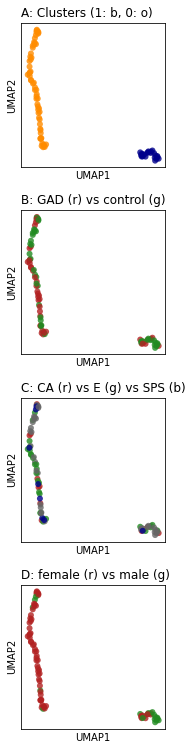

In [6]:
import umap
from sklearn.cluster import KMeans as km
import matplotlib.pyplot as plt
# umap
reducer = umap.UMAP(random_state=44)
embedding = reducer.fit_transform(df.loc[:, features])
embedding = pd.DataFrame(embedding)
#clustering
clusters = km(n_clusters=2).fit_predict(df.loc[:, features])

fig = plt.figure(figsize=[2,2])

ax = fig.add_axes([0,0,1,1])
ax.scatter(embedding[0], embedding[1], c=['darkblue' if x == 1 else 'darkorange' for x in clusters], lw=0, alpha=.8)
ax.set_title('A: Clusters (1: b, 0: o)', fontdict={'fontweight': 500}, loc='left')

ax = fig.add_axes([0,-1.3,1,1])
ax.scatter(embedding[0], embedding[1], c=['firebrick' if status == 'GAD' else 'forestgreen' for status in df.group], lw=0, alpha=.8)
ax.set_title('B: GAD (r) vs control (g)', fontdict={'fontweight': 500}, loc='left')

ax = fig.add_axes([0,-2.6,1,1])
ax.scatter(embedding[0], embedding[1], c=['firebrick' if pt == 1 else 'forestgreen' if pt == 2 else 'darkblue' if pt == 3 else '.4' for pt in df['clinical phenotype 1:CA, 2: encephalitis, 3: SPS']], lw=0, alpha=.8)
ax.set_title('C: CA (r) vs E (g) vs SPS (b)', fontdict={'fontweight': 500}, loc='left')

ax = fig.add_axes([0,-3.9,1,1])
ax.scatter(embedding[0], embedding[1], c=['firebrick' if sex == 2 else 'forestgreen' if sex == 1 else '.4' for sex in df['sex_1m_2f']], lw=0, alpha=.8)
ax.set_title('D: female (r) vs male (g)', fontdict={'fontweight': 500}, loc='left')

for ax in fig.axes:
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')


[plt.savefig(f'./out/pro_gadmri_clusters.{format}', bbox_inches='tight', pad_inches=.1, facecolor='None', transparent=True, dpi=900) for format in ['pdf', 'svg', 'png']]

df['cluster'] = clusters

clusterdf = df.loc[:, ~df.columns.isin(features)]
clusterdf.to_excel('./out/pro_gadmri_dfclusters.xlsx')

[None, None, None]

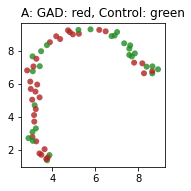

In [7]:
dfcluster0 = df.loc[df.cluster==0, :]

# umap
reducer = umap.UMAP(random_state=44)
embedding = reducer.fit_transform(dfcluster0.loc[:, features])
embedding = pd.DataFrame(embedding)
#clustering
clusters = km(n_clusters=2).fit_predict(dfcluster0.loc[:, features])

fig = plt.figure(figsize=[2,2])

ax = fig.add_axes([0,0,1,1])
ax.scatter(embedding[0], embedding[1], c=['firebrick' if status == 'GAD' else 'forestgreen' for status in dfcluster0.group], lw=0, alpha=.8)
ax.set_title('A: GAD: red, Control: green', fontdict={'fontweight': 500}, loc='left')


[plt.savefig(f'./out/pro_gadmri_cluster0.{format}', bbox_inches='tight', pad_inches=.1, facecolor='None', transparent=True, dpi=900) for format in ['pdf', 'svg', 'png']]

In [5]:
res = pd.DataFrame(index=features)

for feature in features:
    a = dfcluster0.loc[dfcluster0.group == 'GAD', feature]
    b = dfcluster0.loc[dfcluster0.group == 'HC', feature]
    
    p = stats.ttest_ind(a, b).pvalue
    
    cohens_d = (np.mean(a) - np.mean(b)) / (np.sqrt((np.std(a) ** 2 + np.std(b) ** 2) / 2))
    
    res.loc[res.index==feature, 'mean_hc'] = np.mean(b)
    res.loc[res.index==feature, 'mean_gad'] = np.mean(a)
    res.loc[res.index==feature, 'p_gad_hc'] = p
    res.loc[res.index==feature, 'p_gad_hc_sig'] = 1 if p < 0.05 else 0
    res.loc[res.index==feature, 'cohensd_gad_hc'] = cohens_d

res = res.sort_values(by='cohensd_gad_hc')
res.to_excel('out/pro_gadmri_results_cluster0.xlsx')

res

,mean_hc,mean_gad,p_gad_hc,p_gad_hc_sig,cohensd_gad_hc
anterior_lobe,0.008988,0.008737,3.113846e-01,0.0,-0.259982
CerebNet_Gray_Matter,0.067404,0.065946,4.091875e-01,0.0,-0.215996
Vermis,0.003388,0.003316,4.164880e-01,0.0,-0.208795
superior_posterior_lobe,0.043133,0.042296,4.929225e-01,0.0,-0.175763
Cortex,0.292701,0.294769,7.014279e-01,0.0,0.091679
Basal Ganglia,0.012584,0.012737,6.141186e-01,0.0,0.126516
Brain-Stem,0.013504,0.013661,6.177497e-01,0.0,0.126637
X: Lobus flocculonodularis,0.000776,0.000792,5.962709e-01,0.0,0.132821
inferior_posterior_lobe,0.013896,0.014121,5.967994e-01,0.0,0.133631
Corpus_Medullare,0.015074,0.015411,4.257853e-01,0.0,0.203095


In [9]:
df.columns

Index(['PBN_ID', 'group', 'clinical phenotype 1:CA, 2: encephalitis, 3: SPS',
       'sex_1m_2f', 'age_at_scan_y', 'time_since_disease_onset_y', 'eTIV',
       'CerebralWhiteMatter', 'Cortex', 'Brain-Stem', 'Amygdala',
       'Basal Ganglia', 'Hippocampus', 'Thalamus', 'CerebNet_Gray_Matter',
       'Corpus_Medullare', 'Vermis', 'anterior_lobe',
       'superior_posterior_lobe', 'inferior_posterior_lobe', 'cluster'],
      dtype='object')

In [24]:
import statsmodels.api as sm

regmodeldf = df.loc[df.group=='GAD', :]

x = regmodeldf[['age_at_scan_y', 'time_since_disease_onset_y']]
y = regmodeldf['Amygdala']

#x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:               Amygdala   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.846
Method:                 Least Squares   F-statistic:                              110.8
Date:                Sun, 26 Feb 2023   Prob (F-statistic):                    1.40e-16
Time:                        13:17:04   Log-Likelihood:                          227.84
No. Observations:                  40   AIC:                                     -451.7
Df Residuals:                      38   BIC:                                     -448.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------